#**Step 1: Install All the Required Packages**

In [ ]:
# Uninstall existing incompatible packages
!pip uninstall -y bitsandbytes torch torchvision torchaudio

# Install PyTorch with CUDA 11.8 support
!pip install torch==2.1.2+cu118 torchvision==0.16.2+cu118 torchaudio==2.1.2 --index-url https://download.pytorch.org/whl/cu118

# Install bitsandbytes compiled for CUDA 11.8
!pip install bitsandbytes==0.41.1

# Reinstall Transformers and other Hugging Face tools
!pip install -q transformers accelerate peft trl


Found existing installation: bitsandbytes 0.41.1
Uninstalling bitsandbytes-0.41.1:
  Successfully uninstalled bitsandbytes-0.41.1
Found existing installation: torch 2.6.0+cu124
Uninstalling torch-2.6.0+cu124:
  Successfully uninstalled torch-2.6.0+cu124
Found existing installation: torchvision 0.21.0+cu124
Uninstalling torchvision-0.21.0+cu124:
  Successfully uninstalled torchvision-0.21.0+cu124
Found existing installation: torchaudio 2.6.0+cu124
Uninstalling torchaudio-2.6.0+cu124:
  Successfully uninstalled torchaudio-2.6.0+cu124
Looking in indexes: https://download.pytorch.org/whl/cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 GB ? eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 109.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 92.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.2/89.2 MB 8.8 MB/s eta 0:00:00
  Attempting uninstall: triton
    Found existing installation: triton 3.2.0
    Uninstalling

#**Step 2: Import All the Required Libraries**

In [ ]:
import os
import torch
from datasets import load_dataset
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    HfArgumentParser,
    TrainingArguments,
    pipeline,
    logging,
)
from peft import LoraConfig, PeftModel
from trl import SFTTrainer


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py", line 37, in <module>
    ColabKernelApp.launch_instance()
  File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelapp.py", line 712, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.11/dist-package

False

===================================BUG REPORT===================================
The following directories listed in your path were found to be non-existent: {PosixPath('/usr/local/lib/python3.11/dist-packages/cv2/../../lib64')}
The following directories listed in your path were found to be non-existent: {PosixPath('/sys/fs/cgroup/memory.events /var/colab/cgroup/jupyter-children/memory.events')}
The following directories listed in your path were found to be non-existent: {PosixPath('https'), PosixPath('//mp.kaggle.net')}
The following directories listed in your path were found to be non-existent: {PosixPath('http'), PosixPath('8013'), PosixPath('//172.28.0.1')}
The following directories listed in your path were found to be non-existent: {PosixPath('//colab.research.google.com/tun/m/cc48301118ce562b961b3c22d803539adc1e0c19/gpu-t4-s-36agf0h2ez14e --tunnel_background_save_delay=10s --tunnel_periodic_background_save_frequency=30m0s --enable_output_coalescing=true --output_coalescing

/usr/local/lib/python3.11/dist-packages/bitsandbytes/cuda_setup/main.py:166: UserWarning: Welcome to bitsandbytes. For bug reports, please run

python -m bitsandbytes


  warn(msg)
/usr/local/lib/python3.11/dist-packages/bitsandbytes/cuda_setup/main.py:166: UserWarning: /usr/local/lib/python3.11/dist-packages/cv2/../../lib64:/usr/lib64-nvidia did not contain ['libcudart.so', 'libcudart.so.11.0', 'libcudart.so.12.0'] as expected! Searching further paths...
  warn(msg)


RuntimeError: Failed to import transformers.training_args because of the following error (look up to see its traceback):

        CUDA Setup failed despite GPU being available. Please run the following command to get more information:

        python -m bitsandbytes

        Inspect the output of the command and see if you can locate CUDA libraries. You might need to add them
        to your LD_LIBRARY_PATH. If you suspect a bug, please take the information from python -m bitsandbytes
        and open an issue at: https://github.com/TimDettmers/bitsandbytes/issues

#**In case of Llama 2, the following prompt template is used for the chat models**

System Prompt (optional) to guide the model


User prompt (required) to give the instruction


Model Answer (required)

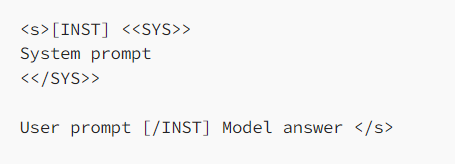

#We will reformat our instruction dataset to follow Llama 2 template.

- Orignal Dataset: https://huggingface.co/datasets/timdettmers/openassistant-guanaco

- Reformat Dataset following the Llama 2 template with 1k sample: https://huggingface.co/datasets/mlabonne/guanaco-llama2-1k

- Complete Reformat Dataset following the Llama 2 template: https://huggingface.co/datasets/mlabonne/guanaco-llama2

To know how this dataset was created, you can check this notebook.  

https://colab.research.google.com/drive/1Ad7a9zMmkxuXTOh1Z7-rNSICA4dybpM2?usp=sharing

### Note: You don’t need to follow a specific prompt template if you’re using the base Llama 2 model instead of the chat version.

#**How to fine tune Llama 2**

- Free Google Colab offers a 15GB Graphics Card (Limited Resources --> Barely enough to store Llama 2–7b’s weights)

- We also need to consider the overhead due to optimizer states, gradients, and forward activations

- Full fine-tuning is not possible here: we need parameter-efficient fine-tuning (PEFT) techniques like LoRA or QLoRA.

- To drastically reduce the VRAM usage, we must fine-tune the model in 4-bit precision, which is why we’ll use LoRA here.

#**Step 3**

1. Load a llama-2-7b-chat-hf model (chat model)
2. Train it on the mlabonne/guanaco-llama2-1k (1,000 samples), which will produce our fine-tuned model Llama-2-7b-chat-finetune

QLoRA will use a rank of 64 with a scaling parameter of 16. We’ll load the Llama 2 model directly in 4-bit precision using the NF4 type and train it for one epoch

In [ ]:
# The model that you want to train from the Hugging Face hub
model_name = "NousResearch/Llama-2-7b-chat-hf"

# meta-llama/Llama-2-7b-chat-hf

# The instruction dataset to use
dataset_name = "mlabonne/guanaco-llama2-1k"

# Fine-tuned model name
new_model = "Llama-2-7b-chat-finetune"

################################################################################
# QLoRA parameters
################################################################################

# LoRA attention dimension
lora_r = 64

# Alpha parameter for LoRA scaling
lora_alpha = 16

# Dropout probability for LoRA layers
lora_dropout = 0.1

################################################################################
# bitsandbytes parameters
################################################################################

# Activate 4-bit precision base model loading
use_4bit = True

# Compute dtype for 4-bit base models
bnb_4bit_compute_dtype = "float16"

# Quantization type (fp4 or nf4)
bnb_4bit_quant_type = "nf4"

# Activate nested quantization for 4-bit base models (double quantization)
use_nested_quant = False

################################################################################
# TrainingArguments parameters
################################################################################

# Output directory where the model predictions and checkpoints will be stored
output_dir = "./results"

# Number of training epochs
num_train_epochs = 1

# Enable fp16/bf16 training (set bf16 to True with an A100)
fp16 = False
bf16 = False

# Batch size per GPU for training
per_device_train_batch_size = 4

# Batch size per GPU for evaluation
per_device_eval_batch_size = 4

# Number of update steps to accumulate the gradients for
gradient_accumulation_steps = 1

# Enable gradient checkpointing
gradient_checkpointing = True

# Maximum gradient normal (gradient clipping)
max_grad_norm = 0.3

# Initial learning rate (AdamW optimizer)
learning_rate = 2e-4

# Weight decay to apply to all layers except bias/LayerNorm weights
weight_decay = 0.001

# Optimizer to use
optim = "paged_adamw_32bit"

# Learning rate schedule
lr_scheduler_type = "cosine"

# Number of training steps (overrides num_train_epochs)
max_steps = -1

# Ratio of steps for a linear warmup (from 0 to learning rate)
warmup_ratio = 0.03

# Group sequences into batches with same length
# Saves memory and speeds up training considerably
group_by_length = True

# Save checkpoint every X updates steps
save_steps = 0

# Log every X updates steps
logging_steps = 25

################################################################################
# SFT parameters
################################################################################

# Maximum sequence length to use
max_seq_length = None

# Pack multiple short examples in the same input sequence to increase efficiency
packing = False

# Load the entire model on the GPU 0
device_map = {"": 0}

#**Step 4:Load everything and start the fine-tuning process**

1. First of all, we want to load the dataset we defined. Here, our dataset is already preprocessed but, usually, this is where you would reformat the prompt, filter out bad text, combine multiple datasets, etc.


2. Then, we’re configuring bitsandbytes for 4-bit quantization.


3. Next, we're loading the Llama 2 model in 4-bit precision on a GPU with the corresponding tokenizer.


4. Finally, we're loading configurations for QLoRA, regular training parameters, and passing everything to the SFTTrainer. The training can finally start!

In [ ]:
# Load dataset (you can process it here)
dataset = load_dataset(dataset_name, split="train")

# Load tokenizer and model with QLoRA configuration
compute_dtype = getattr(torch, bnb_4bit_compute_dtype)

bnb_config = BitsAndBytesConfig(
    load_in_4bit=use_4bit,
    bnb_4bit_quant_type=bnb_4bit_quant_type,
    bnb_4bit_compute_dtype=compute_dtype,
    bnb_4bit_use_double_quant=use_nested_quant,
)

# Check GPU compatibility with bfloat16
if compute_dtype == torch.float16 and use_4bit:
    major, _ = torch.cuda.get_device_capability()
    if major >= 8:
        print("=" * 80)
        print("Your GPU supports bfloat16: accelerate training with bf16=True")
        print("=" * 80)

# Load base model
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map=device_map
)
model.config.use_cache = False
model.config.pretraining_tp = 1

# Load LLaMA tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right" # Fix weird overflow issue with fp16 training

# Load LoRA configuration
peft_config = LoraConfig(
    lora_alpha=lora_alpha,
    lora_dropout=lora_dropout,
    r=lora_r,
    bias="none",
    task_type="CAUSAL_LM",
)

# Set training parameters
training_arguments = TrainingArguments(
    output_dir=output_dir,
    num_train_epochs=num_train_epochs,
    per_device_train_batch_size=per_device_train_batch_size,
    gradient_accumulation_steps=gradient_accumulation_steps,
    optim=optim,
    save_steps=save_steps,
    logging_steps=logging_steps,
    learning_rate=learning_rate,
    weight_decay=weight_decay,
    fp16=fp16,
    bf16=bf16,
    max_grad_norm=max_grad_norm,
    max_steps=max_steps,
    warmup_ratio=warmup_ratio,
    group_by_length=group_by_length,
    lr_scheduler_type=lr_scheduler_type,
    report_to="tensorboard"
)

# Set supervised fine-tuning parameters
trainer = SFTTrainer(
    model=model,
    train_dataset=dataset,
    peft_config=peft_config,
    dataset_text_field="text",
    max_seq_length=max_seq_length,
    tokenizer=tokenizer,
    args=training_arguments,
    packing=packing,
)

# Train model
trainer.train()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001-9ad84bb9cf65a4(…):   0%|          | 0.00/967k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1000 [00:00<?, ? examples/s]

NameError: name 'BitsAndBytesConfig' is not defined

In [ ]:
# Save trained model
trainer.model.save_pretrained(new_model)

##**Step 5: Check the plots on tensorboard, as follows**

In [ ]:
%load_ext tensorboard
%tensorboard --logdir results/runs

###**Step 6:Use the text generation pipeline to ask questions like “What is a large language model?” Note that I’m formatting the input to match Llama 2 prompt template.**

In [ ]:
# Ignore warnings
logging.set_verbosity(logging.CRITICAL)

# Run text generation pipeline with our next model
prompt = "What is a large language model?"
pipe = pipeline(task="text-generation", model=model, tokenizer=tokenizer, max_length=200)
result = pipe(f"<s>[INST] {prompt} [/INST]")
print(result[0]['generated_text'])

In [ ]:
# Empty VRAM
del model
del pipe
del trainer
import gc
gc.collect()
gc.collect()

You can train a Llama 2 model on the entire dataset using [mlabonne/guanaco-llama2](https://huggingface.co/datasets/mlabonne/guanaco-llama2)

#**Step 7: Store New Llama2 Model (Llama-2-7b-chat-finetune)**

How can we store our new Llama-2-7b-chat-finetune model now? We need to merge the weights from LoRA with the base model. Unfortunately, as far as I know, there is no straightforward way to do it: we need to reload the base model in FP16 precision and use the peft library to merge everything.

In [ ]:
# Reload model in FP16 and merge it with LoRA weights
base_model = AutoModelForCausalLM.from_pretrained(
    model_name,
    low_cpu_mem_usage=True,
    return_dict=True,
    torch_dtype=torch.float16,
    device_map=device_map,
)
model = PeftModel.from_pretrained(base_model, new_model)
model = model.merge_and_unload()

# Reload tokenizer to save it
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

#**Step 8: Push Model to Hugging Face Hub**

Our weights are merged and we reloaded the tokenizer. We can now push everything to the Hugging Face Hub to save our model.

In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [ ]:
!huggingface-cli login

model.push_to_hub("entbappy/Llama-2-7b-chat-finetune", check_pr=True)

tokenizer.push_to_hub("entbappy/Llama-2-7b-chat-finetune",check_pr=True)


You can now use this model for inference by loading it like any other Llama 2 model from the Hub.